<a href="https://colab.research.google.com/github/puaqieshang/automatic-labeling-heart-vessels/blob/master/v10_single_heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Update from Previous Version

* Feed single heart into the model 

In [1]:
# Import dependencies

import os
import time
import helper
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import defaultdict

import torch
from torch import tensor, nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the GPU


# Data Retrieval


<table>
  <tr>
    <th>Label</th>
    <th>Class (Vessels)</th>
  </tr>
  <tr>
    <td>0</td>
    <td>LAD</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Diagonals</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Septals</td>
  </tr>
    <tr>
    <td>3</td>
    <td>LCX</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Obtuse Marginal</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Atrials</td>
  </tr>
    <tr>
    <td>6</td>
    <td>LCIM</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Acutes</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Crux</td>
  </tr>
    </tr>
    <tr>
    <td>9</td>
    <td>Unknown</td>
  </tr>
</table>

## Import from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -uq "/content/drive/My Drive/processed.zip"
!ls "/content/" # Lists all the files 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
drive  __MACOSX  processed  sample_data


## Split data into Train/Validate and Test 
Ensures that these 3 data are independent of each other - remove bias

*   Validation - For hyperparameter tuning and model comparison
*   Testing - For Performance Evaluation

Current ratio of Train/Validate:Test = 0.9:0.1

In [3]:
source1 = "/content/processed"

test_dest = "/content/test"

if not os.path.exists(test_dest):
    os.makedirs(test_dest)

folders = os.listdir(source1)
total = 0
import shutil
for singleHeartFolder in folders:

    if singleHeartFolder == ".DS_Store":
        continue


    if np.random.rand(1) < 0.1:
        shutil.move(f"{source1}/{singleHeartFolder}", f"{test_dest}/{singleHeartFolder}")

train_folders = os.listdir(source1)
test_folders = os.listdir(test_dest)

print(f"Total number of train/val samples are {len(train_folders)}")
print(f"Total number of test samples are {len(test_folders)}")

Total number of train/val samples are 290
Total number of test samples are 35


In [4]:
import re

def getLabel(text):
    vessels_names = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'atrials', 
                     'lcim', 'acutes', 'crux', 'unknown']

    try:
        label = re.search("^(.+?)-", text).group(1)     # regex is awesome!
    except AttributeError:
        label = ''  

    return vessels_names.index(label)



In [5]:
MAX_BRANCHES = 16

def storeDataForSingleHeart(dest):

    
    X_singleHeart, y_singleHeart = [], []
    allHearts = os.listdir(dest)

    print(f"There are {len(allHearts)} heart datasets")
    # print(allHearts)

    for singleHeart in allHearts:

        # # print(f"The file is {singleHeart}")   
        # if (singleHeart == ".DS_Store" ):
        #     continue
        X_singleBranch, y_singleBranch = [], []
        if singleHeart == ".DS_Store" or singleHeart == ".test.sh.swp": continue;

        file_des = f"{dest}/{singleHeart}"
        flag=0
        singleHeartFolder=os.listdir(file_des)
        for numOfBranches, f in enumerate(singleHeartFolder, 1):

            if f == ".DS_Store": 
                flag = 1
                continue
            
            # print(f)
            # print(f'{file_des}/{f}')
            geometry = np.genfromtxt(f'{file_des}/{f}')
            geometry = geometry.tolist()
                       
            # print(geometry.shape)
            X_singleBranch.append(geometry)
            label = getLabel(f)
            y_singleBranch.append(label)

    # X_all, y_all = shuffle(np.array(X_all), np.array(y_all), random_state=0) # SHUFFLE?
        if flag == 1:
            remaining = MAX_BRANCHES - numOfBranches +1
        else:
            remaining = MAX_BRANCHES - numOfBranches #16 branches is max
        for i in range(remaining):
            zeroMatrix = np.zeros_like(geometry)
            X_singleBranch.append(zeroMatrix)

            y_singleBranch.append(9) #9 is unknown
        
        X_singleHeart.append(X_singleBranch)
        y_singleHeart.append(y_singleBranch)

    X_all, y_all = np.array(X_singleHeart), np.array(y_singleHeart)

    return X_all, y_all

dest = '/content/processed' # changes this later
X_all, y_all = storeDataForSingleHeart(dest)


print(X_all.shape)
print(y_all.shape)

There are 290 heart datasets
(288, 16, 100, 4)
(288, 16)


In [6]:
unique_elements, counts_elements = np.unique(y_all, return_counts=True)

print(np.asarray((unique_elements, counts_elements)))

print(y_all[0])

[[   0    1    2    3    4    5    6    7    8    9]
 [ 286  295   35  287  195    6   68  220  480 2736]]
[3 7 8 8 7 0 9 9 9 9 9 9 9 9 9 9]


## Develop Custom Dataset

In [7]:
class HeartVesselsDataset(Dataset):

    # Initialize your data, download, etc.
    def __init__(self, attributes_data, labels):

        self.x_data = attributes_data # Access dict
        self.y_data = labels # Access dict
        self.len = labels.shape[0]
        
    # USE DICTIONARY
    def __getitem__(self, index):
        # print(index)
        geometry = self.x_data[index]
        label = self.y_data[index] # Its a number
        # print(label)
        
        return geometry, np.array(label)


    def __len__(self):
        return len(self.x_data)



Create Validation Datasets using KFold

Cross validation (CV) is one of the technique used to test the effectiveness of a machine learning models, it is also a re-sampling procedure used to evaluate a model if we have a limited data

In [8]:
from sklearn.model_selection import KFold # import KFold
X = X_all 
print(f"Before splitting, the data has this shape - {X.shape}")
y = y_all

kf = KFold(n_splits=4,random_state=None, shuffle=False) # Define the split - into 5 folds 
# kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 

for train_index, val_index in kf.split(X):
    # print(val_index)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]


print(f"\nAfter splitting, the training data has this shape - {X_train.shape}")
print(f"After splitting, the validation data has this shape - {X_val.shape}")

Before splitting, the data has this shape - (288, 16, 100, 4)
KFold(n_splits=4, random_state=None, shuffle=False)

After splitting, the training data has this shape - (216, 16, 100, 4)
After splitting, the validation data has this shape - (72, 16, 100, 4)


In [11]:
BATCH_SIZE = 16
train_dataset = HeartVesselsDataset(X_train, y_train)
trainloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=False,num_workers=0)

val_dataset = HeartVesselsDataset(X_val, y_val)
valloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,shuffle=False,num_workers=0)

print(f"Train has {len(trainloader)} batches and {train_dataset.len} datasets")
print(f"Validation has {len(valloader)} batches and {val_dataset.len} datasets")


Train has 14 batches and 216 datasets
Validation has 5 batches and 72 datasets


## Inspecting Input - A Single Branch

torch.Size([16, 16, 100, 4])
torch.Size([16, 16])

A Random Coronary Branch
Dimension of a single heart dataset is torch.Size([16, 100, 4])
Dimension of a single branch is torch.Size([100, 4])


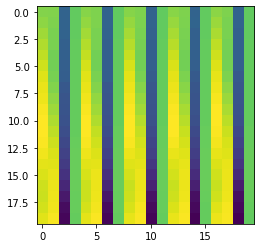

The label is 3


In [12]:
geometries, label = next(iter(trainloader))

print(geometries.shape)
print(label.shape)

# print(f"Geo is of type {geometries.type}")
# print(f"Label is of type {label.type}")
print("\nA Random Coronary Branch")
print(f"Dimension of a single heart dataset is {geometries[0].shape}")
print(f"Dimension of a single branch is {geometries[0][0].shape}")

plt.imshow(geometries[0][0].view(20, 20))
plt.show()
print(f"The label is {label[0][0]}")

In [ ]:
print(label[0][0])

tensor(7)


# Model Definition

So that different model architectures can work interchangeable



## Linear Layers

### Model 1 - nn.Linear in Sequential Form

A simple Multi-Layer Perceptron, but achieves accuracy of 0.78 - 0.8 after 350 epochs

In [ ]:
# model = nn.Sequential(nn.Linear(400,128), nn.ReLU(), nn.Linear(128,64), 
#                       nn.ReLU(), nn.Linear(64,9), nn.LogSoftmax(dim=1))

# model = model.to(device)

### Model 2 - nn.Linear in Class form 
Basically same as Model 1, just that its in nn.functional() form. This allows user to tune the parameters more, which is better. 


In [ ]:
# # Start Timer
# t0 = time.time()


# class ConvNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Defining the layers, 128, 64, 9 units each
#         self.fc1 = nn.Linear(400, 128)
#         self.fc2 = nn.Linear(128, 64)
#         # Output layer, 9 units - one for each digit
#         self.fc3 = nn.Linear(64, 9)
        
#     def forward(self, x):
#         ''' Forward pass through the network, returns the output logits '''
        
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = F.log_softmax(x, dim=1)
        
#         return x


# model = ConvNN()
# model = model.to(device)

## Convolutional Layers

Suggestions to Improve:
* Use He Initialization for ReLU layers instead of random or zero initiliazation. Refer to roadmap
* Use more regularization techniques (if necessary)

Things to note:
* Increasing number of layers by more than 2 do not improve the accuracy - could be due to my model being simple?
* No need to have a lot of nodes in a hidden layer; the input is not a 2D image anyways.
* [Dropout Layers FAQ ](https://https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network )
* Dropout layers may result in [Test Accuracy > Train Accuracy](https://www.quora.com/How-can-I-explain-the-fact-that-test-accuracy-is-much-higher-than-train-accuracy)  

### Model 3 - Conv1D with 3 Hidden Layers

Tested on different pooling layers:
*   Max Pooling
*   Average Pooling
*   Global Max Pooling
*   Global Average Pooling


In [13]:
class ConvNN_single_heart(nn.Module):


    def __init__(self):
        super().__init__()
        
        # Input Tensor [batch, in_channels, in_width]

        # Random Initialization
        # input = (batch_size, no of channels, height, width)
        x = torch.rand(16, 100, 4).view(-1, 4, 16, 100)

        # He initialization variants
        # x = torch.empty(100, 4).view(-1, 4, 100)    
        # x = nn.init.kaiming_uniform_(x, mode='fan_out', nonlinearity='relu')
        # x = nn.init.kaiming_normal_(x, mode='fan_in', nonlinearity='relu')

        # Defining the layers, 4, 8, 16 and 32 units each
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size = (1,3))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size = (1,3))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size = (1,3))
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,3))
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(1,3))

        # Activated during eval mode
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4_bn = nn.BatchNorm2d(512)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(32)
    
        self.fc_dropout = nn.Dropout(p=0.5)
        self.conv_dropout = nn.Dropout(p=0.1)
        
        self._to_linear = None
        # Time distributed layer - maybe change to keras
        self.convs(x)
        
        # self.fc1 = nn.Linear(self._to_linear, 64) #flattening.
        # self.fc2 = nn.Linear(64, 9) # 64 in, 9out bc we're doing 9 classes 

        self.fc1 = nn.Linear(self._to_linear, 128) #flattening.
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10) # 10 labels

    def convs(self, x):
        # max pooling over 2
        
        x = self.conv1(x)
        x = self.conv1_bn(x)  
        x = F.relu(x)
        x = self.conv_dropout(x)    
        x = F.max_pool2d(x, (1,2)) #or Elu

        # print(x.shape)
        x = self.conv2(x)
        x = self.conv2_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool2d(x, (1,2)) #or Elu

        # print(x.shape)
        x = self.conv3(x)
        x = self.conv3_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool2d(x, (1,2)) #or Elu
        
        x = self.conv4(x)
        x = self.conv4_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool2d(x, (1,2)) #or Elu

        x = self.conv5(x)
        x = self.conv4_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool2d(x, (1,2)) #or Elu
        
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[2]
            
        return x
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.convs(x)
        # .view is reshape ... this flattens X before going to FC layer
       
        # print(x.shape)
        x = x.view(-1, 16, self._to_linear)  
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        x = x.view(-1, x.shape[2], x.shape[1])
        x = self.fc1_bn(x)
        x = F.relu(x)
        x = self.fc_dropout(x) 

        # print(x.shape)
        x = x.view(-1, x.shape[2], x.shape[1])
        x = self.fc2(x) # bc this is our output layer. No activation here.
        # print(x.shape)
        x = x.view(-1, x.shape[2], x.shape[1])
        
        x = self.fc2_bn(x)
        x = F.relu(x)
        x = self.fc_dropout(x)   

        # print(x.shape)
        x = x.view(-1, x.shape[2], x.shape[1])
        x = self.fc3(x)

        # print(x.shape)
        return F.log_softmax(x, dim=1)
        
        
        return x


###Different Pooling Layers
Suboptimal models with varying pooling layers are shelved

In [ ]:
class ConvNN_avgpool(nn.Module):


    def __init__(self):
        super().__init__()
        
        # Input Tensor [batch, in_channels, in_width]

        # Random Initialization
        x = torch.rand(100, 4).view(-1, 4, 100)

        # He initialization variants
        # x = torch.empty(100, 4).view(-1, 4, 100)    
        # x = nn.init.kaiming_uniform_(x, mode='fan_out', nonlinearity='relu')
        # x = nn.init.kaiming_normal_(x, mode='fan_in', nonlinearity='relu')

        # Defining the layers, 4, 8, 16 and 32 units each
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=256, kernel_size=3)

        # Activated during eval mode
        self.conv1_bn = nn.BatchNorm1d(16)
        self.conv2_bn = nn.BatchNorm1d(64)
        self.conv3_bn = nn.BatchNorm1d(256)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(32)
    
        self.fc_dropout = nn.Dropout(p=0.5)
        self.conv_dropout = nn.Dropout(p=0.1)
        
        self._to_linear = None
        # Time distributed layer - maybe change to keras
        self.convs(x)
        
        # self.fc1 = nn.Linear(self._to_linear, 64) #flattening.
        # self.fc2 = nn.Linear(64, 9) # 64 in, 9out bc we're doing 9 classes 

        self.fc1 = nn.Linear(self._to_linear, 128) #flattening.
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 9)

    def convs(self, x):
        # max pooling over 2
        
        x = self.conv1(x)
        x = self.conv1_bn(x)  
        x = F.relu(x)
        x = self.conv_dropout(x)    
        # print(x.shape)
        # x = F.max_pool1d(x, 2, 1) # (input, kernel_size, stride) 
        # kernel_size will downsize a 2x2 matrix into a single pixel/number
        x = F.avg_pool1d(x, kernel_size=3, stride=2)
        # print(x.shape)

        x = self.conv2(x)
        x = self.conv2_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)

        # print(x.shape)
        # x = F.max_pool1d(x, 2, 1) # (input, kernel_size, stride) 
        # kernel_size will downsize a 2x2 matrix into a single pixel/number
        x = F.avg_pool1d(x, kernel_size=3, stride=2)
        # print(x.shape)

        x = self.conv3(x)
        x = self.conv3_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)

        # print(x.shape)
        # x = F.max_pool1d(x, 2, 1) # (input, kernel_size, stride) 
        # kernel_size will downsize a 2x2 matrix into a single pixel/number
        x = F.avg_pool1d(x, kernel_size=3, stride=2)
        # print(x.shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
            
        return x
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        

        x = self.convs(x)
        # .view is reshape ... this flattens X before going to FC layer
        x = x.view(-1, self._to_linear)  

        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        x = self.fc_dropout(x) 

        x = self.fc2(x) # bc this is our output layer. No activation here.
        x = self.fc2_bn(x)
        x = F.relu(x)
        x = self.fc_dropout(x)   

        x = self.fc3(x)
        # print(x.shape)
        return F.log_softmax(x, dim=1)
        
        return x


In [ ]:
class ConvNN_GAP(nn.Module):


    def __init__(self):
        super().__init__()
        
        # Input Tensor [batch, in_channels, in_width]

        # Random Initialization
        x = torch.rand(100, 4).view(-1, 4, 100)

        # He initialization variants
        # x = torch.empty(100, 4).view(-1, 4, 100)    
        # x = nn.init.kaiming_uniform_(x, mode='fan_out', nonlinearity='relu')
        # x = nn.init.kaiming_normal_(x, mode='fan_in', nonlinearity='relu')

        # Defining the layers, 4, 8, 16 and 32 units each
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=256, kernel_size=3)

        # Activated during eval mode
        self.conv1_bn = nn.BatchNorm1d(16)
        self.conv2_bn = nn.BatchNorm1d(64)
        self.conv3_bn = nn.BatchNorm1d(256)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(32)
    
        self.fc_dropout = nn.Dropout(p=0.5)
        self.conv_dropout = nn.Dropout(p=0.1)
        
        self._to_linear = None
        # Time distributed layer - maybe change to keras
        self.convs(x)
        
        # self.fc1 = nn.Linear(self._to_linear, 64) #flattening.
        # self.fc2 = nn.Linear(64, 9) # 64 in, 9out bc we're doing 9 classes 

        self.fc1 = nn.Linear(256, 9) #flattening.
        # self.fc2 = nn.Linear(16, 9)

    def convs(self, x):
        # max pooling over 2
        
        x = self.conv1(x)
        x = self.conv1_bn(x)  
        x = F.relu(x)
        x = self.conv_dropout(x)    
        x = F.max_pool1d(x, 2) #or Elu

        x = self.conv2(x)
        x = self.conv2_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool1d(x, 2) #or Elu

        x = self.conv3(x)
        x = self.conv3_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool1d(x, 2) #or Elu
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
            
        return x
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.convs(x)
        # print(x.shape)
        # .view is reshape ... this flattens X before going to FC layer
        # x = x.view(-1, self._to_linear)  
        
        x = torch.mean(x,dim=2)
        # print(x.shape)
        # print(x)
        x = self.fc_dropout(x)
        x = self.fc1(x) # bc this is our output layer. No activation here.
        # print(x.shape)

        # x = self.fc2_bn(x)
        # x = F.relu(x)
        # x = self.fc_dropout(x)   

        return F.log_softmax(x, dim=1)
        
        return x


In [ ]:
class ConvNN_GMP(nn.Module):


    def __init__(self):
        super().__init__()
        
        # Input Tensor [batch, in_channels, in_width]

        # Random Initialization
        x = torch.rand(100, 4).view(-1, 4, 100)

        # He initialization variants
        # x = torch.empty(100, 4).view(-1, 4, 100)    
        # x = nn.init.kaiming_uniform_(x, mode='fan_out', nonlinearity='relu')
        # x = nn.init.kaiming_normal_(x, mode='fan_in', nonlinearity='relu')

        # Defining the layers, 4, 8, 16 and 32 units each
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=256, kernel_size=3)

        # Activated during eval mode
        self.conv1_bn = nn.BatchNorm1d(16)
        self.conv2_bn = nn.BatchNorm1d(64)
        self.conv3_bn = nn.BatchNorm1d(256)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(32)
    
        self.fc_dropout = nn.Dropout(p=0.5)
        self.conv_dropout = nn.Dropout(p=0.1)
        
        self._to_linear = None
        # Time distributed layer - maybe change to keras
        self.convs(x)
        
        # self.fc1 = nn.Linear(self._to_linear, 64) #flattening.
        # self.fc2 = nn.Linear(64, 9) # 64 in, 9out bc we're doing 9 classes 

        self.fc1 = nn.Linear(256, 9) #flattening.
        # self.fc2 = nn.Linear(16, 9)

    def convs(self, x):
        # max pooling over 2
        
        x = self.conv1(x)
        x = self.conv1_bn(x)  
        x = F.relu(x)
        x = self.conv_dropout(x)    
        x = F.max_pool1d(x, 2) #or Elu

        x = self.conv2(x)
        x = self.conv2_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool1d(x, 2) #or Elu

        x = self.conv3(x)
        x = self.conv3_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool1d(x, 2) #or Elu
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
            
        return x
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.convs(x)
        # print(x.shape)
        # .view is reshape ... this flattens X before going to FC layer
        # x = x.view(-1, self._to_linear)  
        
        x, _ = torch.max(x,dim=2)
        # print(x.shape)
        # print(x.shape)
        # print(x)
        x = self.fc_dropout(x)
        x = self.fc1(x) # bc this is our output layer. No activation here.
        # print(x.shape)

        # x = self.fc2_bn(x)
        # x = F.relu(x)
        # x = self.fc_dropout(x)   

        return F.log_softmax(x, dim=1)
        
        return x



### Model 4 - Conv1D with 2 Layers

The node layers and numbers are based on multiple websites:
https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

https://www.researchgate.net/post/In_neural_networks_model_which_number_of_hidden_units_to_select


In [ ]:
# class ConvNN(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # Input Tensor [batch, in_channels, in_width]
#         x = torch.randn(100, 4).view(-1, 4, 100)

        
#         self.conv1 = nn.Conv1d(in_channels=4, out_channels=7, kernel_size=3) 
#         self.conv2 = nn.Conv1d(in_channels=7, out_channels=5, kernel_size=3)
#         self.conv1_bn = nn.BatchNorm1d(7)
#         self.conv2_bn = nn.BatchNorm1d(5)
#         self.fc_dropout = nn.Dropout(p=0.5)
#         self.conv_dropout = nn.Dropout(p=0.1)
        
#         self._to_linear = None

#         self.convs(x)

#         self.fc1 = nn.Linear(self._to_linear, 64) #flattening.
#         self.fc2 = nn.Linear(64, 9) # 64 in, 9out bc we're doing 9 classes 

#     def convs(self, x):
#         # max pooling over 2
#         x = self.conv1(x)
#         x = self.conv1_bn(x)       
#         x = F.max_pool1d(self.conv_dropout(F.relu(x)), 2) #or Elu

#         x = self.conv2(x)
#         x = self.conv2_bn(x)       
#         x = F.max_pool1d(self.conv_dropout(F.relu(x)), 2) #or Elu

#         # x = self.conv3(x)
#         # # x = self.conv3_bn(x)       
#         # x = F.max_pool1d(F.relu(x), 2) #or Elu
        
#         if self._to_linear is None:
#             self._to_linear = x[0].shape[0]*x[0].shape[1]
            
#         return x
        
#     def forward(self, x):
#         ''' Forward pass through the network, returns the output logits '''
        
#         x = self.convs(x)
#         x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 

#         x = self.fc1(x)
#         # x = self.fc1_bn(x)
#         x = F.relu(x)
#         x = self.fc_dropout(x) 

#         x = self.fc2(x) # bc this is our output layer. No activation here.
#         return F.log_softmax(x, dim=1)
        
#         return x


# Train and Validate Model




```
model.train(), model.eval()
```

Both are the same. By default all the modules are initialized to train mode (self.training = True). 

In case you want to validate your data, call model.eval() before feeding the data, as this will change the behavior of the BatchNorm (or Dropout) layer to use the running estimates instead of calculating them for the current batch.
If you want to train your model and can’t use a bigger batch size, you could switch e.g. to InstanceNorm.

In [15]:
model = ConvNN_single_heart()
model = model.to(device)

In [14]:
def train(loader): # for train cases
    running_loss = 0
    sumCorrect = 0
    sumTotal = 0      
    size = 0
    model.train() # for train cases
        
    for X, y in loader:
        
        X = X.view(-1, 4, 16, 100) # feed "-1" batch size 
        # print(X.shape)
        X, y = X.to(device), y.to(device)
        # print(f"hello {y.shape}")
        
        optimiser.zero_grad()
        
        # train_X = train_X.view(-1, 4, 100)
        output = model(X.float())
        
        _, predicted = torch.max(output.data, 2)
        # print(predicted.shape)

        
        for input, target in zip(output, y):
            loss_per_minibatch = 0
            # print (input.shape, target.shape)
            loss = criterion(input,target)
            loss_per_minibatch += loss.item()
            # print(loss_per_minibatch)

            running_loss += loss_per_minibatch/BATCH_SIZE
            size += 1
            # print("-----")
       
        loss.backward()
        
        optimiser.step()
        
        # Accuracy
        for predict, y_correct in zip(predicted, y):
            # print(predict, y_correct)
            sumCorrect += (predict == y_correct).sum().item()
        
            sumTotal += y.size(1)

    l = running_loss/size #average loss for whole loader dataset
    acc = sumCorrect/sumTotal

    return acc, l

def validate(loader):
    running_loss = 0
    sumCorrect = 0
    sumTotal = 0 
    size = 0   

    model.eval() # for validation cases
    with torch.no_grad():   
        for X, y in loader:

            X = X.view(-1, 4, 16, 100)
            # print(X.shape)
            X, y = X.to(device), y.to(device)
            
            
            # train_X = train_X.view(-1, 4, 100)
            output = model(X.float())
            
            _, predicted = torch.max(output.data, 2)
         
            for input, target in zip(output, y):

                loss_per_minibatch = 0
                # print (input.shape, target.shape)
                loss = criterion(input,target)
                loss_per_minibatch += loss.item()

                running_loss += loss_per_minibatch/BATCH_SIZE
                size += 1
                    

            # Accuracy
            for predict, y_correct in zip(predicted, y):
            # print(predict.shape, y_correct.shape)
                sumCorrect += (predict == y_correct).sum().item()

                sumTotal += y.size(1)
            
            # print(sumTotal)   

    l = running_loss/size #average loss for whole loader dataset
    acc = sumCorrect/sumTotal

    return acc, l

def train_and_validate(trainloader, valloader):
    train_acc_list, train_loss_list, val_acc_list, val_loss_list = [],[],[],[]
    
    for e in tqdm(range(EPOCHS), position=0, leave=True):

        # Train
        train_acc, train_loss = train(trainloader)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        
        # Validate
        val_acc, val_loss = validate(valloader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
    
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list

## Calculate Accuracy and Loss - *Testing (Not the Main Program)*

In [16]:
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Refer to Deep Learning Roadmap

EPOCHS = 2
train_acc_total, train_loss_total, val_acc_total, val_loss_total = [],[],[],[]
for i in range(EPOCHS):
    
    a, b, c, d = train_and_validate(trainloader, valloader)
  
    train_acc_total.append(a)
    train_loss_total.append(b) 
    val_acc_total.append(c) 
    val_loss_total.append(d) 


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


In [17]:
print(train_acc_total)
print(train_loss_total)
print("------------------")
print(val_acc_total)
print(val_loss_total)

[[0.12384259259259259, 0.1316550925925926], [0.12818287037037038, 0.12731481481481483]]
[[0.1799049771356362, 0.17832671347315665], [0.17665089439186785, 0.17571445982213374]]
------------------
[[0.10503472222222222, 0.12760416666666666], [0.1605902777777778, 0.18229166666666666]]
[[0.17334381221897072, 0.17292252224352625], [0.17235539274083245, 0.17190176414118874]]


# Visualization



## See Validation Results for 1 Sample (FIX ME!)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
vessels_names = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'atrials', 'lcim', 'acutes', 'crux', 'unknown']


dataiter = iter(valloader)
geometries, labels = dataiter.next()

# Convert 2D matrix/image to 1D vector

geom = geom.resize_(1, 400)


# TODO: Calculate the class probabilities (softmax) for img
with torch.no_grad():
    
    logps = model(geom.cuda().view(-1, 4, 100).float()) # convert to cuda tensor to run faster
    
ps = torch.exp(logps)

# Plot the image and probabilities

def view_classify(geom, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(geom.resize_(20, 20).numpy().squeeze()) #First figure on left
    
    ax1.axis('off')
    ax2.barh(np.arange(10), ps) #Make a horizontal bar plot
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(11))
    ax2.set_yticklabels(vessels_names, size='medium');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


geom_numpy = geom.cpu().numpy()
view_classify(geom.reshape(20, 20), ps) # convert back to numpy

print(f"The actual vessel is {vessels_names[labels[0]]}")


NameError: ignored

## Plot Accuracies and Loss vs Epochs

This fucntion is used to average the five fold train and validation accuracy and loss. It won't be useful if we are tying to tune the hyperparameters OR just training on one dataset. 

In [ ]:

def averaging(train_acc_total, train_loss_total, val_acc_total, val_loss_total):

    train_acc_total = np.asarray(train_acc_total)
    train_loss_total = np.asarray(train_loss_total)
    val_acc_total = np.asarray(val_acc_total)
    val_loss_total = np.asarray(val_loss_total)

    # print(train_acc_total)
    firstRow = train_acc_total[:, 0]
    # print(firstRow)
    # print(np.average(firstRow))

    train_acc_avg, train_loss_avg, val_acc_avg, val_loss_avg =[], [],[],[]

    for i in range(train_acc_total.shape[1]):
        mean_acc = np.average(train_acc_total[:, i])
        train_acc_avg.append(mean_acc)

        mean_loss = np.average(train_loss_total[:, i])
        train_loss_avg.append(mean_loss)

        mean_acc = np.average(val_acc_total[:, i])
        val_acc_avg.append(mean_acc)

        mean_loss = np.average(val_loss_total[:, i])
        val_loss_avg.append(mean_loss)

    return train_acc_avg, train_loss_avg, val_acc_avg, val_loss_avg

Average Accuracy and Loss for Train and Val

In [20]:
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

style.use("ggplot")

def create_acc_loss_graph(train_acc_list, train_loss_list, val_acc_list, val_loss_list):
    epoch = list(range(0, EPOCHS, 1))

    d = {'epochs': epoch,
        'train_acc': train_acc_list,
        'train_loss': train_loss_list,
        'val_acc': val_acc_list, 
        'val_loss': val_loss_list}

    df = pd.DataFrame(d)

    df['train_acc_avg'] = df['train_acc'].ewm(alpha=.02).mean()  # exponential weighted moving average
    df['val_acc_avg'] = df['val_acc'].ewm(alpha=.02).mean()
    df['train_loss_avg'] = df['train_loss'].ewm(alpha=.02).mean()
    df['val_loss_avg'] = df['val_loss'].ewm(alpha=.02).mean()

    # Then plot using pandas:
    df.plot(x='epochs', y=['train_acc_avg', 'val_acc_avg'], figsize=(8,4))
    plt.ylabel("Accuracy")
    df.plot(x='epochs', y=['train_loss_avg', 'val_loss_avg'], figsize=(8,4))
    plt.ylabel("Loss")

    plt.show()



## Compare Validation Sets

Validation Set is used to compare diff models and tune hyperparamters to get the optimum one.



In [ ]:
from scipy.interpolate import make_interp_spline, BSpline

def compare_graph(x, y, parameter, compare):

    plt.figure()

    for i in range(len(x)):

        # 300 represents number of points to make between T.min and T.max
        x_smooth = np.linspace(min(x[i]), max(x[i]), 300)  
        spline = make_interp_spline(x[i], y[i], k=3)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f"Model = {i}")

        # plt.plot(x[i], y[i], label=f"batch size = {parameter[i]}")
    
    plt.xlabel('Epochs')
    
    if compare is "acc":
        plt.ylabel('Accuracy')
        plt.legend(loc="lower right")
    else:
        plt.ylabel('Loss')
        plt.legend(loc="upper right")
    
    plt.show()


# Main Pipeline
24/6/2020 - Curerntly used for hyperparameter tuning through Five-fold cross validation

26/6/2020 - The parameters that are selected for pruning are:

*   Learning rate 
*   batch size
*   weight initialization - random and He initialization, random is better
*   Different pooling layers and Global Pooling Layers




In [ ]:
import statistics as stats

accuracies = []

modelsArray = [ConvNN_avgpool(), ConvNN_maxpool(), ConvNN_GAP(), ConvNN_GMP()]
learningRate = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch = [8, 16, 32, 64, 128]

X = X_all 
y = y_all # Create another array
kf = KFold(n_splits=4,random_state=None, shuffle=False) # shuffle was fale

train_acc_total, train_loss_total, val_acc_total, val_loss_total = [],[],[],[]
epochs_total=[]

i = 0
for train_index, val_index in kf.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    train_dataset = HeartVesselsDataset(X_train, y_train)
    trainloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True,num_workers=0)

    val_dataset = HeartVesselsDataset(X_val, y_val)
    valloader = DataLoader(dataset=val_dataset, batch_size=16,shuffle=True,num_workers=0)

    model = modelsArray[i]
    model = model.to(device)

    t0 = time.time()
    criterion = nn.NLLLoss()
    optimiser = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    EPOCHS = 200# at least 5 for the interpoaltion to work
    e = list(range(0, EPOCHS))

    train_acc_list, train_loss_list, val_acc_list, val_loss_list = train_and_validate(trainloader, valloader)
    
    train_acc_total.append(train_acc_list)
    train_loss_total.append(train_loss_list) 
    val_acc_total.append(val_acc_list) 
    val_loss_total.append(val_loss_list) 
    epochs_total.append(e)

    t1 = time.time()
    duration = (t1-t0)/60
    print("\nTime taken to train for 1 validation set is " + "{:.2f}".format(duration) + " minutes.")

    i+= 1

compare_graph(epochs_total, val_acc_total, modelsArray, compare="acc")
compare_graph(epochs_total, val_loss_total, modelsArray, compare="loss")

# To get acc and loss for both val and test
# a,b,c,d = averaging(train_acc_total, train_loss_total,  val_acc_total, val_loss_total)
# create_acc_loss_graph(a,b,c,d )

# print(f"\nThis model has an accuracy of {round(max(accuracies), 3)} +/- {round(stats.stdev(accuracies), 3)}")      

In [ ]:
modelsArray = [ConvNN_avgpool(), ConvNN_maxpool(), ConvNN_GAP(), ConvNN_GMP()]

for counter, val_list in enumerate(val_acc_total):
    maxValue = max(val_list)
    print(f"Model {counter} has a max accuracy of {round(maxValue, 3)} at epoch {val_list.index(maxValue)}")

# Training on Most Optimum Model

So far the deafult model - **ConvNN_maxpool()** has the best performance

In [21]:
# Decide which model is the best
model = ConvNN_single_heart()
model = model.to(device)

100%|██████████| 800/800 [02:09<00:00,  6.20it/s]


Time taken to train for 1 validation set is 2.15 minutes.



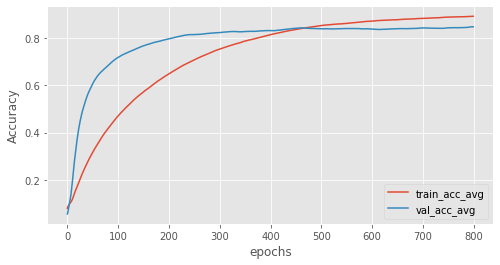

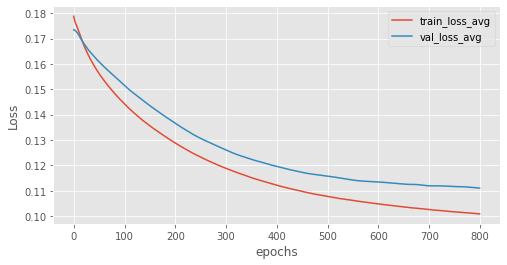


This model has an accuracy of 0.852 and loss of 0.111


In [22]:
import statistics as stats

accuracies = []

learningRate = 0.0001
batch = 16


X = X_all 
y = y_all # Create another array

train_ratio = 0.8

train_index = list(range(0, int(train_ratio*len(X))))
val_index = list(range(int(train_ratio*len(X)), len(X)-1))

X_train, X_val = X[train_index], X[val_index]
y_train, y_val = y[train_index], y[val_index]

train_dataset = HeartVesselsDataset(X_train, y_train)
trainloader = DataLoader(dataset=train_dataset, batch_size=batch,shuffle=True,num_workers=0)

val_dataset = HeartVesselsDataset(X_val, y_val)
valloader = DataLoader(dataset=val_dataset, batch_size=batch,shuffle=True,num_workers=0)



t0 = time.time()
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-4)

EPOCHS = 800# at least 5 for the interpoaltion to work

train_acc_list, train_loss_list, val_acc_list, val_loss_list = train_and_validate(trainloader, valloader)

t1 = time.time()
duration = (t1-t0)/60
print("Time taken to train for 1 validation set is " + "{:.2f}".format(duration) + " minutes.\n")

create_acc_loss_graph(train_acc_list, train_loss_list, val_acc_list, val_loss_list)

# To get acc and loss for both val and test
# a,b,c,d = averaging(train_acc_total, train_loss_total,  val_acc_total, val_loss_total)
# create_acc_loss_graph(a,b,c,d )

print(f"\nThis model has an accuracy of {round(val_acc_list[-1], 3)} and loss of {round(val_loss_list[-1], 3)}")      

# Test Model on Unseen Data 
Well technically, `model.eval() `is not learning any new weights so its testing

In [ ]:
# !rm -r /content/test
dest = '/content/test/'
X_test, y_test = storeDataForSingleHeart(dest)

test_dataset = HeartVesselsDataset(X_test, y_test)
testloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

There are 28 heart datasets


In [ ]:
vessels_names = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'atrials', 'lcim', 'acutes', 'crux', 'unknown']

def test(model):

    correct = 0
    total = 0
    vessels_count = np.zeros((10,), dtype=int)
    vessels_correct = np.zeros((10,), dtype=int)
    mainBifurcations_count = np.zeros((3,), dtype=int) 
    mainBifurcations_correct = np.zeros((3,), dtype=int) 

    predicted_class_array = []
    true_class_array = []

    with torch.no_grad():

        model.eval()

        for test_X, test_y in testloader:

            test_X, test_y = test_X.to(device), test_y.to(device)

            # for i in tqdm(range(len(test_X)), position=0, leave=True):
            for X, y in zip(test_X, test_y):
                test_y_list = y.tolist()
                # true_class_array.append(test_y)
                true_class_array.extend(test_y_list)
                X = X.view(-1, 4, 16, 100) # feed "-1" batch size 
                # print(X.shape)
                X, y = X.to(device), y.to(device)
                # print(f"hello {y.shape}")

                # train_X = train_X.view(-1, 4, 100)
                output = model(X.float())

                _, predicted = torch.max(output.data, 2)
                predicted = predicted[0].cpu().data.numpy()
                # print(predicted)
                predicted_class_array.extend(predicted)

                for predict, real in zip(predicted, y):
                    real = real.item()
                    if real == 9: #exclude unknowns
                        continue
                    
                    vessels_count[real] += 1
            

                    if predict == real:
                        vessels_correct[real] += 1
                        correct += 1
                    
                    # These numbers follow the sequence in the "vessels_name" list
                    # print(predicted_class)
                    else:
                        if predict in {0, 1, 2} and real in {0, 1, 2}:
                                # print(f"predicted {predicted_class}, real {real_class}")
                                mainBifurcations_correct[0] += 1

                        elif predict in {3, 4} and real in {3, 4}:
                                # print(f"predicted {predicted_class}, real {real_class}")
                                mainBifurcations_correct[1] += 1
                        
                        elif predict in {7, 8} and real in {7, 8}:
                                mainBifurcations_correct[2] += 1

                    # print("hello")
                    total += 1


    print("\n\nOverall Accuracy (excluding unknowns) is:", round(correct/total,3))
    print("------------------------")

    for i in range(len(vessels_count)):
        acc = round(vessels_correct[i]/vessels_count[i],3)
        string = f"Accuracy of {vessels_names[i]} is:"
        print("{:<30} {:<5}".format(string, acc))

    print("------------------------")
    print(f"No of samples for each vessel in a batch is {vessels_count}")

    mainBifurcations_count[0] = vessels_count[0] + vessels_count[1] + vessels_count[2] #LCA
    mainBifurcations_count[1] = vessels_count[3] + vessels_count[4] #LCX
    mainBifurcations_count[2] = vessels_count[7] + vessels_count[8] #RCA 

    mainBifurcations_correct[0] += vessels_correct[0] + vessels_correct[1] + vessels_correct[2]  #LCA
    mainBifurcations_correct[1] += vessels_correct[3] + vessels_correct[4]  #LCX
    mainBifurcations_correct[2] += vessels_correct[7] + vessels_correct[8]  #RCA

    print("------------------------")
    print(f"Bifurcation LCA has accuracy of {round(mainBifurcations_correct[0]/mainBifurcations_count[0], 3)}")
    print(f"Bifurcation LCX has accuracy of {round(mainBifurcations_correct[1]/mainBifurcations_count[1], 3)}")
    print(f"Bifurcation RCA has accuracy of {round(mainBifurcations_correct[2]/mainBifurcations_count[2], 3)}")

    # print(test_y)
    return true_class_array, predicted_class_array


true_class_array, predicted_class_array = test(model)




Overall Accuracy (excluding unknowns) is: 0.767
------------------------
Accuracy of ldai is:           0.962
Accuracy of diags is:          0.69 
Accuracy of septals is:        1.0  
Accuracy of lcxi is:           0.815
Accuracy of obtmar is:         0.4  
Accuracy of atrials is:        nan  
Accuracy of lcim is:           0.0  
Accuracy of acutes is:         0.88 
Accuracy of crux is:           0.822
Accuracy of unknown is:        nan  
------------------------
No of samples for each vessel in a batch is [26 29  1 27 20  0  3 25 45  0]
------------------------
Bifurcation LCA has accuracy of 0.893
Bifurcation LCX has accuracy of 0.851
Bifurcation RCA has accuracy of 0.929


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in long_scalars


# Analysis 

## Confusion Matrix

In [ ]:
from sklearn import metrics

# y_true = np.array()

# True values
y_true = true_class_array
# Predicted values
y_pred = predicted_class_array

y_true, y_pred = zip(*[(i, j) for i, j in zip(y_true, y_pred) if i !=9]) # zip(*..) is unzip


# Print the confusion matrix
array=metrics.confusion_matrix(y_true, y_pred)
print(array)


[[25  1  0  0  0  0  0  0]
 [ 2 20  1  0  5  1  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  1  0 22  4  0  0  0]
 [ 0  4  1  6  8  1  0  0]
 [ 0  1  1  0  1  0  0  0]
 [ 0  0  0  0  0  0 22  3]
 [ 2  0  0  1  1  1  3 37]]


In [ ]:
# Print the precision and recall, among other metrics
vessels_names_without_unknowns = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'lcim', 'acutes', 'crux']
print(metrics.classification_report(y_true, y_pred, digits=3, target_names=vessels_names_without_unknowns))

              precision    recall  f1-score   support

        ldai      0.862     0.962     0.909        26
       diags      0.741     0.690     0.714        29
     septals      0.250     1.000     0.400         1
        lcxi      0.759     0.815     0.786        27
      obtmar      0.421     0.400     0.410        20
        lcim      0.000     0.000     0.000         3
      acutes      0.880     0.880     0.880        25
        crux      0.925     0.822     0.871        45

    accuracy                          0.767       176
   macro avg      0.605     0.696     0.621       176
weighted avg      0.777     0.767     0.769       176



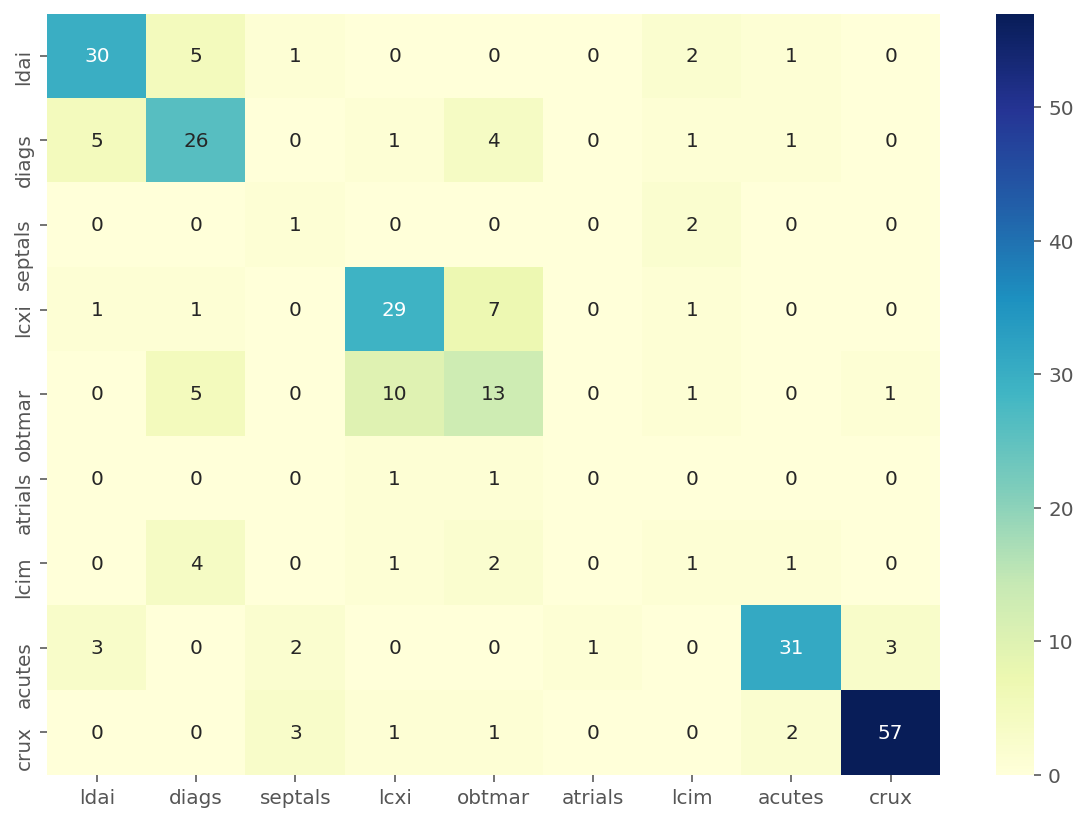

In [ ]:
import seaborn as sn
vessels_names_without_unknowns = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'atrials', 'lcim', 'acutes', 'crux']
df_cm = pd.DataFrame(array, index = [i for i in vessels_names_without_unknowns],
                  columns = [i for i in vessels_names_without_unknowns])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='d')

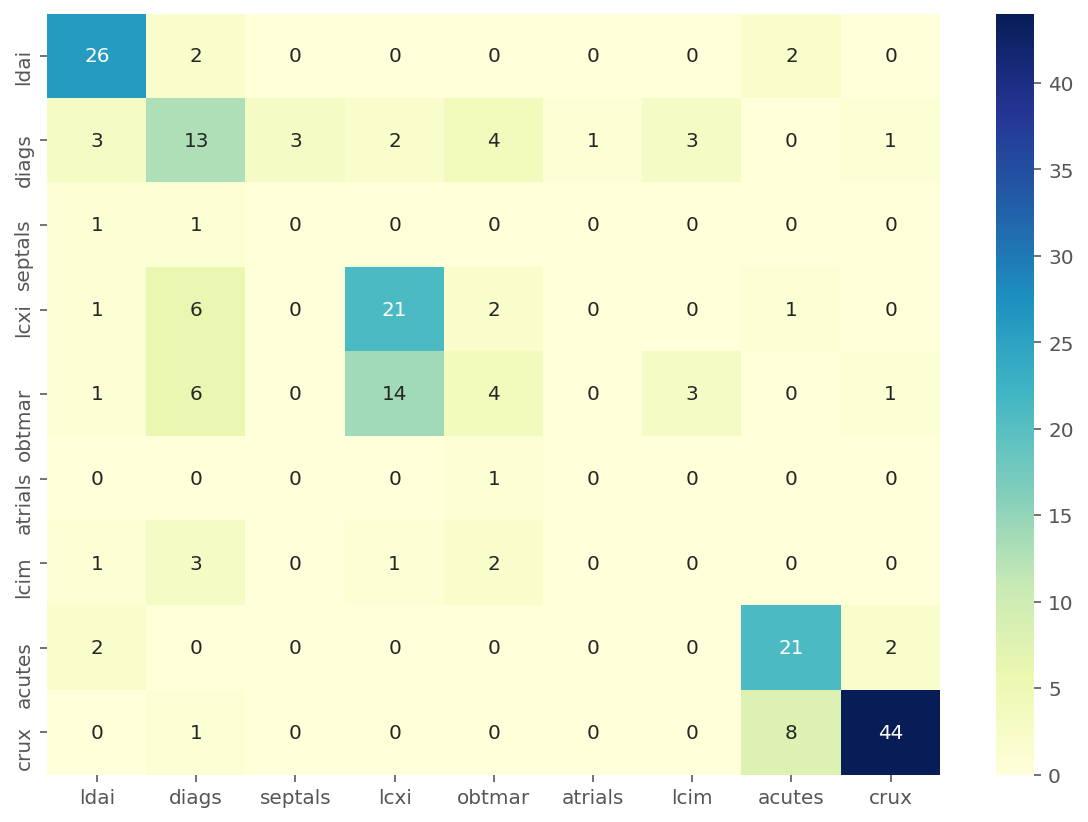

In [ ]:
# import seaborn as sn


# # remove unknown labels 
# array = array[0:-1, 0:-1]

# vessels_names = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'atrials', 'lcim', 'acutes', 'crux']
# df_cm = pd.DataFrame(array, index = [i for i in vessels_names],
#                   columns = [i for i in vessels_names])
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='d')

# Appendix A - Displays Model Information

In [ ]:
# Move all the files in the test folder back to the main folder 

import os
import shutil
source = '/content/test'
dest1 = '/content/processed'
folders = os.listdir(source)

for folder in folders:

    if folder == ".DS_Store":
        continue
    new_folder_path = f"{source}/{folder}"

    single_folder = os.listdir(new_folder_path)

    for f in single_folder:
        shutil.move(f"{new_folder_path}/{f}", f"{dest1}/{folder}")


In [ ]:
# from torchvision import models
# model = models.vgg16()
print(model)

ConvNN_single_heart(
  (conv1): Conv2d(4, 16, kernel_size=(1, 3), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(1, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_dropout): Dropout(p=0.5, inplace=False)
  (conv_dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=2560, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
# Prints the model's state for each layer
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print the weights of the model - A LOT OF MATRICES
# print("Optimizer's state_dict:")
# for var_name in optimiser.state_dict():
#     print(var_name, "\t", optimiser.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([16, 4, 1, 3])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([64, 16, 1, 3])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([256, 64, 1, 3])
conv3.bias 	 torch.Size([256])
conv1_bn.weight 	 torch.Size([16])
conv1_bn.bias 	 torch.Size([16])
conv1_bn.running_mean 	 torch.Size([16])
conv1_bn.running_var 	 torch.Size([16])
conv1_bn.num_batches_tracked 	 torch.Size([])
conv2_bn.weight 	 torch.Size([64])
conv2_bn.bias 	 torch.Size([64])
conv2_bn.running_mean 	 torch.Size([64])
conv2_bn.running_var 	 torch.Size([64])
conv2_bn.num_batches_tracked 	 torch.Size([])
conv3_bn.weight 	 torch.Size([256])
conv3_bn.bias 	 torch.Size([256])
conv3_bn.running_mean 	 torch.Size([256])
conv3_bn.running_var 	 torch.Size([256])
conv3_bn.num_batches_tracked 	 torch.Size([])
fc1_bn.weight 	 torch.Size([128])
fc1_bn.bias 	 torch.Size([128])
fc1_bn.running_mean 	 torch.Size([128])
fc1_bn.running_var 	 torch.Size([128])
fc1_bn.num_batches_tracked 	 

In [ ]:

total_params = sum(p.numel() for p in model.parameters())

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The total params are {total_params} and the trainable one are {trainable_params}")


The total params are 1305562 and the trainable one are 1305562
